In [1]:
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8

model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

/Users/YusMolina/miniconda3/envs/tesis4/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import cv2



In [3]:
import torch
from urllib.request import urlopen
from PIL import Image
import os



template = ' The breast is '
labels = ["Characterized by scattered areas of pattern density",
        "Fatty predominance",
        "Extremely dense",
        "Heterogeneously dense"]

image_dir = '/Users/YusMolina/Documents/tesis/biomedCLIP/tesisMamogra/4kimages'
# 
df = pd.read_csv("/Users/YusMolina/Documents/tesis/biomedCLIP/secondChance/generatedReports4Path.csv")
test_imgs = df["img_name"]
#shuffled_df.to_csv("/Users/YusMolina/Documents/tesis/biomedCLIP/secondChance/generatedReports4Path.csv")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

context_length = 20

#It runs the model on the preprocessed images and tokenized texts to get image and text features.
#images = torch.stack([preprocess(Image.open(urlopen(dataset_url + img))) for img in test_imgs]).to(device)
# Load and preprocess the images
import torch
import cv2
import os
from PIL import Image
import torchvision.transforms as transforms

# Define transformation: Resize + Convert to Tensor
to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))  # Resize to 255x255
    
])

images = torch.stack([
    to_tensor(Image.fromarray(cv2.cvtColor(cv2.imread(os.path.join(image_dir, img)), cv2.COLOR_BGR2RGB)))
    for img in test_imgs
]).to(device)




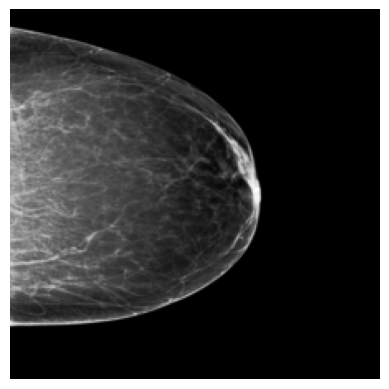

In [4]:
import matplotlib.pyplot as plt

# Convert tensor to NumPy and move to CPU
image = images[0].cpu().numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)

# Scale to 0-255 and convert to uint8
image = (image * 255).astype("uint8")

# Display
plt.imshow(image)
plt.axis("off")
plt.show()


In [ ]:

texts = tokenizer([template + l for l in labels], context_length=context_length).to(device)
with torch.no_grad(): #used for inference 
    image_features, text_features, logit_scale = model(images, texts)
    #It computes logits (unnormalized predictions) by comparing image and text features.
    logits = (logit_scale * image_features @ text_features.t()).detach().softmax(dim=-1) #compute similarity score ebtween images and text feature
    sorted_indices = torch.argsort(logits, dim=-1, descending=True)
    #logits -> probability distribution over the possible classes for each input image.
    logits = logits.cpu().numpy()
    sorted_indices = sorted_indices.cpu().numpy()

import pandas as pd

# Initialize an empty list to store results
results = []

top_k = -1

for i, img in enumerate(test_imgs):
    pred = labels[sorted_indices[i][0]]

    top_k = len(labels) if top_k == -1 else top_k
    image_name = img.split('/')[-1]
    top_label = labels[sorted_indices[i][0]]

    # Append to results
    results.append({'Image Name': image_name, 'Top Label': top_label})

# Create DataFrame
df = pd.DataFrame(results)

df
# Optionally, save to CSV
#df.to_csv('top_predictions.csv', index=False)


In [ ]:
df.to_csv('top_predictions.csv', index=False)

In [ ]:
images.size()

In [ ]:
import matplotlib.pyplot as plt

def plot_images_with_metadata(images, metadata):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize=(5, 5 * num_images))

    for i, (img_path, metadata) in enumerate(zip(images, metadata)):
        img = Image.open(os.path.join(image_dir, img_path))

        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{metadata['filename']}\n{metadata['top_probs']}", fontsize=14)

    plt.tight_layout()
    plt.show()

metadata_list = []

top_k = 3
for i, img in enumerate(test_imgs):
    pred = labels[sorted_indices[i][0]]
    img_name = img.split('/')[-1]

    top_probs = []
    top_k = len(labels) if top_k == -1 else top_k
    for j in range(top_k):
        jth_index = sorted_indices[i][j]
        top_probs.append(f"{labels[jth_index]}: {logits[i][jth_index] * 100:.1f}")

    metadata = {'filename': img_name, 'top_probs': '\n'.join(top_probs)}
    metadata_list.append(metadata)

plot_images_with_metadata(test_imgs, metadata_list)

Compare the actual classes vs the output of the biomedclip

In [ ]:

df_original = pd.read_csv("/Users/YusMolina/Documents/tesis/biomedCLIP/secondChance/generatedReports4Path.csv")
df_original

In [ ]:

#top_predictions.csv
#
df_predicted = pd.read_csv("/Users/YusMolina/Documents/tesis/biomedCLIP/pre_model/top_predictions.csv")
df_predicted

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_breast_density_classification(actual_df, predicted_df):
    """
    Evaluate breast density classification by comparing actual vs predicted labels.
    
    Parameters:
    -----------
    actual_df : pandas.DataFrame
        DataFrame containing actual labels with columns ['img_name', 'breast_density']
    predicted_df : pandas.DataFrame
        DataFrame containing predicted labels with columns ['Image Name', 'Top Label']
    
    Returns:
    --------
    dict
        Dictionary containing overall and per-class metrics
    """
    # Rename columns to match
    predicted_df = predicted_df.rename(columns={'Image Name': 'img_name', 'Top Label': 'predicted'})
    actual_df = actual_df.rename(columns={'breast_density': 'actual'})
    
    # Merge datasets on image name
    merged_df = pd.merge(actual_df[['img_name', 'actual']], 
                        predicted_df[['img_name', 'predicted']], 
                        on='img_name', 
                        how='inner')
    
    # Calculate overall metrics
    overall_accuracy = accuracy_score(merged_df['actual'], merged_df['predicted'])
    overall_f1 = f1_score(merged_df['actual'], merged_df['predicted'], average='weighted')
    
    # Get detailed classification report
    class_report = classification_report(merged_df['actual'], 
                                       merged_df['predicted'], 
                                       output_dict=True)
    
    # Calculate confusion matrix
    labels = sorted(set(merged_df['actual'].unique()) | set(merged_df['predicted'].unique()))
    conf_matrix = confusion_matrix(merged_df['actual'], 
                                 merged_df['predicted'],
                                 labels=labels)
    
    # Calculate per-class metrics
    per_class_metrics = {}
    
    for class_label in labels:
        class_actual = (merged_df['actual'] == class_label).astype(int)
        class_pred = (merged_df['predicted'] == class_label).astype(int)
        
        class_accuracy = accuracy_score(class_actual, class_pred)
        class_f1 = f1_score(class_actual, class_pred, average='binary')
        
        per_class_metrics[class_label] = {
            'accuracy': class_accuracy,
            'f1_score': class_f1,
            'support': len(merged_df[merged_df['actual'] == class_label])
        }
    
    # Prepare results dictionary
    results = {
        'overall_metrics': {
            'accuracy': overall_accuracy,
            'f1_score': overall_f1,
            'total_samples': len(merged_df)
        },
        'per_class_metrics': per_class_metrics,
        'confusion_matrix': conf_matrix,
        'labels': labels
    }
    
    return results

def plot_confusion_matrix(conf_matrix, labels, title='Confusion Matrix'):
    """
    Plot confusion matrix using seaborn heatmap.
    
    Parameters:
    -----------
    conf_matrix : numpy.ndarray
        Confusion matrix to plot
    labels : list
        List of class labels
    title : str
        Title for the plot
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def print_evaluation_results(results):
    """
    Print evaluation results in a formatted way and plot confusion matrix.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation metrics
    """
    print("\n=== Overall Metrics ===")
    print(f"Total Samples: {results['overall_metrics']['total_samples']}")
    print(f"Overall Accuracy: {results['overall_metrics']['accuracy']:.4f}")
    print(f"Overall F1 Score: {results['overall_metrics']['f1_score']:.4f}")
    
    print("\n=== Per-Class Metrics ===")
    for class_label, metrics in results['per_class_metrics'].items():
        print(f"\nClass: {class_label}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f}")
        print(f"Support: {metrics['support']}")
    
    print("\n=== Confusion Matrix ===")
    print(pd.DataFrame(
        results['confusion_matrix'], 
        index=results['labels'],
        columns=results['labels']
    ))
    
    # Plot the confusion matrix
    plot_confusion_matrix(results['confusion_matrix'], results['labels'])

# Example usage:
"""
# Load your datasets
actual_df = pd.read_csv('actual_labels.csv')
predicted_df = pd.read_csv('predicted_labels.csv')

# Run evaluation
results = evaluate_breast_density_classification(actual_df, predicted_df)

# Print results and plot confusion matrix
print_evaluation_results(results)
"""
   

In [ ]:
results = evaluate_breast_density_classification(df_original, df_predicted)

# Print results
print_evaluation_results(results)